#Installing and Importing libraries

Need mount your Google Drive folder, make sure you change the directory to the one where you paste the entire repository

In [136]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/mydir')

# Define the path for the folder where you want to clone the repository
folder_path = '/content/mydir/MyDrive/GQME_Tutorial'

# Create the folder if it doesn't already exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Created folder: {folder_path}")

# Change the current working directory to the folder where you want to clone the repository
os.chdir(folder_path)

# Clone the GitHub Repository into the specified folder
!git clone https://github.com/XiaohanDan97/CCI_PartIII_GQME .

Drive already mounted at /content/mydir; to attempt to forcibly remount, call drive.mount("/content/mydir", force_remount=True).
fatal: destination path '.' already exists and is not an empty directory.


In [ ]:
import numpy as np
np.float = float
np.complex = complex
import time

#parameters in the simulation
from params import *
#read and write functions
import readwrite as wr

import matplotlib.pyplot as plt

SPIN-BOSON Model parameter
        epsilon = 1
             xi = 0.1
        omega_c = 2
      omega_max = 10
     time steps = 2000
             DT = 0.0015008299950527925
     final time = 3.001659990105585
          DOF_E = 2
          DOF_N = 60


#Using TT-TFD to simulate Spin-Boson Model Dynamics

The tensor-train library, ttpy, is available at https://github.com/oseledets/ttpy and must be on your computer before doing the TT-TFD.

In [ ]:
#The two block below calculates dynamics with TT-TFD. The expected waiting time is 10 minutes on Google Colab.
#To save time, the results are already pre-computed and saved.
#The following code would still run normally without running the two block below.
!pip install git+https://github.com/bcallen95/ttpy.git --quiet

In [ ]:
import tt_tfd as tfd

#RDO: reduced density operator, contain the information of population and coherence
#initial_state=0: initial at Donor state
t, RDO_arr = tfd.tt_tfd(initial_state=0)

#TT-TFD is time consuming, after running it once, you can read it from the file without running it again
#output to the file
wr.output_operator_array(t, RDO_arr, "TTTFD_Output/TFDSigma_")

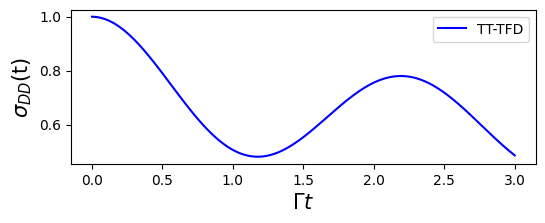

In [ ]:
#read and plot
t, RDO_arr = wr.read_operator_array("TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(t, RDO_arr[:,0].real,'b-', label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

#Using GQME to simulate Spin-Boson Model dynamics

##The projected Liouvillian

In [ ]:
LN0 = np.zeros((DOF_E_SQ, DOF_E_SQ))
LN0[0][1] = LN0[1][0] = LN0[2][3] = LN0[3][2] = -GAMMA_DA
LN0[0][2] = LN0[2][0] = LN0[1][3] = LN0[3][1] = GAMMA_DA
LN0[1][1] = 2. * EPSILON
LN0[2][2] = -2. * EPSILON

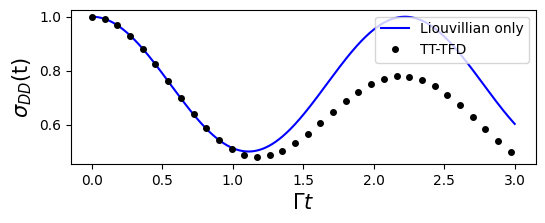

In [ ]:
from scipy.linalg import expm
sigma_liou = np.zeros((TIME_STEPS, DOF_E_SQ), dtype=np.complex_)
time_arr = np.linspace(0,(TIME_STEPS-1)*DT,TIME_STEPS)
sigma_liou[0] = np.array([1.0,0,0,0],dtype=np.complex_)
for i in range(1,TIME_STEPS):
  sigma_liou[i] = expm(-1j*LN0*i*DT)@sigma_liou[0]

#read TT-TFD result and plot to compare
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
plt.figure(figsize=(6,2))
plt.plot(time_arr, sigma_liou[:,0].real,'b-', label='Liouvillian only')
plt.plot(timeVec,  sigma_tt_tfd[:,0].real,'ko', markersize=4,markevery=60, label='TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

## Calculating the Memory Kernel

### The Projection-Free Inputs

In [ ]:
def cal_U_tt_tfd():

    U = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

    # tt-tfd with initial state 0,1,2,3
    # initial state |0> means donor state |D>, |3> means acceptor state |A>
    # |1> is (|D> + |A>)/sqrt(2), |2> is (|D> + i|A>)/sqrt(2)
    t,U[:,:,0] = tfd.tt_tfd(0)
    t,U[:,:,1] = tfd.tt_tfd(1)
    t,U[:,:,2] = tfd.tt_tfd(2)
    t,U[:,:,3] = tfd.tt_tfd(3)

    U_final = U.copy()

    # the coherence elements that start at initial state |D><A| and |A><D|
    # is the linear combination of above U results
    # |D><A| = |1><1| + i * |2><2| - 1/2 * (1 + i) * (|0><0| + |3><3|)
    U_final[:,:,1] = U[:,:,1] + 1.j * U[:,:,2] - 0.5 * (1. + 1.j) * (U[:,:,0] + U[:,:,3])

    # |A><D| = |1><1| - i * |2><2| - 1/2 * (1 - i) * (|0><0| + |3><3|)
    U_final[:,:,2] = U[:,:,1] - 1.j * U[:,:,2] - 0.5 * (1. - 1.j) * (U[:,:,0] + U[:,:,3])

    #output U
    wr.output_superoper_array(t,U_final,"U_Output/U_")

    return 0

In [ ]:
#The line below calculates all U elements with TT-TFD. The expected waiting time is 40 minutes on Google Colab.
#To save time, the results are already pre-computed and saved, and this line is therefore commented out.
#The following code would still run normally. Please uncomment if one wishes to perform these calculations.
#cal_U_tt_tfd()

In [ ]:
def cal_F():
    #read the propagator data from files
    timeVec,U = wr.read_superoper_array("U_Output/U_")

    F = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)
    Fdot = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

    for j in range(DOF_E_SQ):
        for k in range(DOF_E_SQ):
            # extracts real and imag parts of U element
            Ureal = U[:,j,k].copy().real
            Uimag = U[:,j,k].copy().imag

            # F = i * d/dt U so Re[F] = -1 * d/dt Im[U] and Im[F] = d/dt Re[U]
            Freal = -1. * np.gradient(Uimag.flatten(), DT, edge_order = 2)
            Fimag = np.gradient(Ureal.flatten(), DT, edge_order = 2)

            # Fdot = d/dt F so Re[Fdot] = d/dt Re[F] and Im[Fdot] = d/dt Im[F]
            Fdotreal = np.gradient(Freal, DT)
            Fdotimag = np.gradient(Fimag, DT)

            F[:,j,k] = Freal[:] + 1.j * Fimag[:]
            Fdot[:,j,k] = Fdotreal[:] + 1.j * Fdotimag[:]

    #write the result to the file
    wr.output_superoper_array(timeVec,F,"ProjFree_Output/F_")
    wr.output_superoper_array(timeVec,Fdot,"ProjFree_Output/Fdot_")

    return timeVec,F,Fdot

In [ ]:
timeVec,F,Fdot = cal_F()

###volterra scheme: calculating the Memory kernel and output to the file

In [ ]:
linearTerm = 1.j * Fdot.copy() # first term of the linear part
for l in range(TIME_STEPS):
    # subtracts second term of linear part
    linearTerm[l,:,:] -= 1./HBAR * F[l,:,:] @ LN0

In [ ]:
def CalculateIntegral(DOF_E_SQ, F, linearTerm, prevKernel, kernel):

    # time step loop starts at 1 because K is equal to linear part at t = 0
    for n in range(1, TIME_STEPS):
        kernel[n,:,:] = 0.

        # f(a) and f(b) terms
        kernel[n,:,:] += 0.5 * DT * F[n,:,:] @ kernel[0,:,:]
        kernel[n,:,:] += 0.5 * DT * F[0,:,:] @ prevKernel[n,:,:]

        # sum of f(a + kh) term
        for c in range(1, n):
            # since a new (supposed-to-be-better) guess for the
            # kernel has been calculated for previous time steps,
            # can use it rather than prevKernel
            kernel[n,:,:] += DT * F[n - c,:,:] @ kernel[c,:,:]

        # multiplies by i and adds the linear part
        kernel[n,:,:] = 1.j * kernel[n,:,:] + linearTerm[n,:,:]

    return kernel

In [ ]:
START_TIME = time.time() # starts timing
# sets initial guess to the linear part
prevKernel = linearTerm.copy()
kernel = linearTerm.copy()

# loop for iterations
for numIter in range(1, MAX_ITERS + 1):

    iterStartTime = time.time() # starts timing of iteration
    print("Iteration:", numIter)

    # calculates kernel using prevKernel and trapezoidal rule
    kernel = CalculateIntegral(DOF_E_SQ, F, linearTerm, prevKernel, kernel)

    numConv = 0 # parameter used to check convergence of entire kernel
    for i in range(DOF_E_SQ):
        for j in range(DOF_E_SQ):
            for n in range(TIME_STEPS):
                # if matrix element and time step of kernel is converged, adds 1
                if abs(kernel[n][i][j] - prevKernel[n][i][j]) <= CONVERGENCE_PARAM:
                    numConv += 1

                # if at max iters, prints which elements and time steps did not
                # converge and prevKernel and kernel values
                elif numIter == MAX_ITERS:
                    print("\tK time step and matrix element that didn't converge: %s, %s%s"%(n,i,j))

    print("\tIteration time:", time.time() - iterStartTime)

    # enters if all times steps and matrix elements of kernel converged
    if numConv == TIME_STEPS * DOF_E_SQ * DOF_E_SQ:
        # prints number of iterations and time necessary for convergence
        print("Number of Iterations:", numIter, "\tVolterra time:", time.time() - START_TIME)

        # prints memory kernel to files
        wr.output_superoper_array(timeVec,kernel,"K_Output/K_")

        break # exits the iteration loop

    # if not converged, stores kernel as prevKernel, zeros the kernel, and then
    # sets kernel at t = 0 to linear part
    prevKernel = kernel.copy()
    kernel = linearTerm.copy()

    # if max iters reached, prints lack of convergence
    if numIter == MAX_ITERS:
        print("\tERROR: Did not converge for %s iterations"%MAX_ITERS)
        print("\tVolterra time:", print(time.time() - START_TIME))

Iteration: 1
	Iteration time: 15.791362524032593
Iteration: 2
	Iteration time: 15.246119737625122
Iteration: 3
	Iteration time: 15.434304237365723
Iteration: 4
	Iteration time: 15.30905795097351
Iteration: 5
	Iteration time: 15.254355669021606
Iteration: 6
	Iteration time: 15.538378953933716
Number of Iterations: 6 	Volterra time: 92.58530974388123


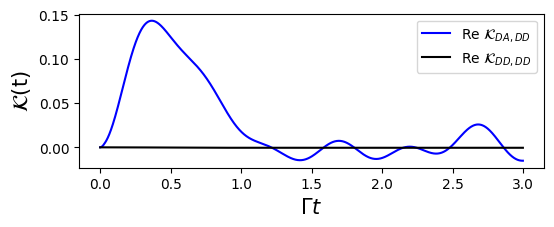

In [ ]:
#plot the kernel without the last two boundary points that have numerical errors
plt.figure(figsize=(6,2))
plt.plot(timeVec[:-2], kernel[:-2,1,0].real,'b-', label='Re $\mathcal{K}_{DA,DD}$')
plt.plot(timeVec[:-2], kernel[:-2,0,0].real,'k-', label='Re $\mathcal{K}_{DD,DD}$')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\mathcal{K}$(t)',fontsize=15)
plt.legend(loc = 'upper right')

##Propagate the GQME

In [ ]:
def PropagateRK4(currentTime, memTime, kernel,
                 sigma_hold, sigma):

    f_0 = Calculatef(currentTime, memTime,
                     kernel, sigma, sigma_hold)

    k_1 = sigma_hold + DT * f_0 / 2.
    f_1 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_1)

    k_2 = sigma_hold + DT * f_1 /2.
    f_2 = Calculatef(currentTime + DT / 2., memTime,
                     kernel, sigma, k_2)

    k_3 = sigma_hold + DT * f_2
    f_3 = Calculatef(currentTime + DT, memTime,
                     kernel, sigma, k_3)

    sigma_hold += DT / 6. * (f_0 + 2. * f_1 + 2. * f_2 + f_3)

    return sigma_hold


In [ ]:
def Calculatef(currentTime, memTime, kernel, sigma_array, kVec):
    global LN0, HBAR

    memTimeSteps = int(memTime / DT)
    currentTimeStep = int(currentTime / DT)

    f_t = np.zeros(kVec.shape, dtype=np.complex_)

    f_t -= 1.j / HBAR * LN0 @ kVec

    limit = memTimeSteps
    if currentTimeStep < (memTimeSteps - 1):
        limit = currentTimeStep
    for l in range(limit):
        f_t -= DT * kernel[l,:,:] @ sigma_array[currentTimeStep - l]

    return f_t


In [ ]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array("K_Output/K_")

# array for reduced density matrix elements
sigma = np.zeros((TIME_STEPS, DOF_E_SQ), dtype=np.complex_)
# array to hold copy of sigma
sigma_hold = np.zeros(DOF_E_SQ, dtype = np.complex_)

# sets the initial state at Donor State
sigma[0,0] = 1.
sigma_hold[0] = 1.

# loop to propagate sigma
print(">>> Starting GQME propagation, memory time =", MEM_TIME)
for l in range(TIME_STEPS - 1): # it propagates to the final time step
    if l%100==0: print(l)
    currentTime = l * DT

    sigma_hold = PropagateRK4(currentTime, MEM_TIME, kernel, sigma_hold, sigma)

    sigma[l + 1] = sigma_hold.copy()

# prints sigma to files
wr.output_operator_array(timeVec, sigma, "GQME_Output/Sigma_")

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


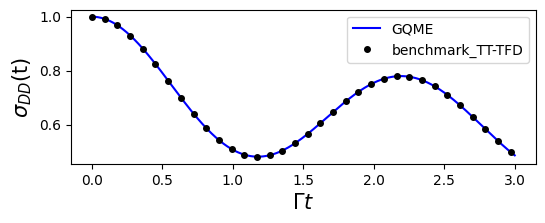

In [ ]:
# Read the reference data and plot
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
timeVec, sigma = wr.read_operator_array("GQME_Output/Sigma_")

plt.figure(figsize=(6,2))
plt.plot(timeVec, sigma[:,0],'b-', label='GQME')
plt.plot(timeVec, sigma_tt_tfd[:,0] ,'ko', markersize=4, markevery=60, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend()

# Quantum Algorithms of GQME based on Dilation

## Solving the GQME to get the propagator

In [ ]:
#read the memory kernel
timeVec,kernel = wr.read_superoper_array("K_Output/K_")

# array for Propagator superoperator elements
G_prop = np.zeros((TIME_STEPS, DOF_E_SQ, DOF_E_SQ), dtype=np.complex_)

#time 0 propagator: identity superoperator
G_prop[0] = np.eye(DOF_E_SQ)
#array to hold copy of G propagator
G_prop_hold = np.eye((DOF_E_SQ), dtype=np.complex_)

# loop to propagate G_prop using GQME
print(">>> Starting GQME propagation, memory time =", MEM_TIME)
for l in range(TIME_STEPS - 1): # it propagates to the final time step
    if l%100==0: print(l)
    currentTime = l * DT

    G_prop_hold = PropagateRK4(currentTime, MEM_TIME, kernel, G_prop_hold, G_prop)

    G_prop[l + 1] = G_prop_hold.copy()

>>> Starting GQME propagation, memory time = 3.001659990105585
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


## Dilation of the non-unitary propagator

In [ ]:
from numpy import linalg as la
import scipy.linalg as sp

def dilate(array):

  # Normalization factor of 1.5 to ensure contraction
  norm = la.norm(array,2)*1.5
  array_new = array/norm

  ident = np.eye(array.shape[0])

  # Calculate the conjugate transpose of the G propagator
  fcon = (array_new.conjugate()).T

  # Calculate the defect matrix for dilation
  fdef = sp.sqrtm(ident - np.dot(fcon, array_new))

  # Calculate the defect matrix for the conjugate of the G propagator
  fcondef = sp.sqrtm(ident - np.dot(array_new, fcon))

  # Dilate the G propagator to create a unitary operator
  array_dilated = np.block([[array_new, fcondef], [fdef, -fcon]])

  return array_dilated, norm

## Quantum Simulation of GQME with QASM Simulator

In [ ]:
!pip install qiskit==0.45
!pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 25.0 MB/s eta 0:00:00


In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator
from qiskit.compiler import transpile

In [ ]:
# Create a dictionary to store the measurement results
result = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 0}

# Create lists to store the population for the acceptor and donor states
pop_accept = []
pop_donor = []

# initial state in the dilated space
rho0_dilated = np.concatenate((np.array([1 + 0j, 0, 0, 0]),np.zeros(DOF_E_SQ)))

for i in range(TIME_STEPS):

    qr = QuantumRegister(3)  # Create a quantum register with 3 qubits
    cr = ClassicalRegister(3)  # Create a classical register to store measurement results
    qc = QuantumCircuit(qr, cr)  # Combine the quantum and classical registers to create the quantum circuit

    # Initialize the quantum circuit with the initial state
    qc.initialize(rho0_dilated, qr)

    # Dilated propagator
    U_G, norm = dilate(G_prop[i])

    # Create a custom unitary operator with the dilated propagator
    U_G_op = Operator(U_G)

    # Apply the unitary operator to the quantum circuit's qubits
    qc.unitary(U_G_op, qr)
    # Measure the qubits and store the results in the classical register
    qc.measure(qr, cr)

    #Run the Simulation and Plot the Results
    shots = 2000  # Number of shots
    counts = execute(qc, Aer.get_backend('qasm_simulator'), shots=shots).result().get_counts()

    # Update the result dictionary
    for x in counts:
        result[x] = counts[x]

    # Calculate the populations of donor and acceptor states from measurement probabilities
    pd = np.sqrt(result['000'] / 2000) * norm  # Multiply by the normalization factor
    pa = np.sqrt(result['011'] / 2000) * norm  # Multiply by the normalization factor

    pop_donor.append(pd)  # Stacking the population for the donor state
    pop_accept.append(pa)  # Stacking the population for the acceptor state

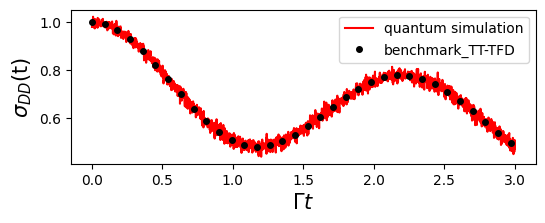

In [ ]:
# Read the exact TT-TFD results
timeVec, sigma_tt_tfd = wr.read_operator_array("TTTFD_Output/TFDSigma_")
# Plot the population of the donor and acceptor states
plt.figure(figsize=(6,2))
plt.plot(timeVec, pop_donor, 'r-', label="quantum simulation")
plt.plot(timeVec, sigma_tt_tfd[:,0].real ,'ko', markersize=4, markevery=60, label='benchmark_TT-TFD')
plt.xlabel('$\Gamma t$',fontsize=15)
plt.ylabel('$\sigma_{DD}$(t)',fontsize=15)
plt.legend(loc = 'upper right')